# CatBoost Starter for Brain Comp
EEGの差分の集計特徴量を用いたNotebook。

- ver1: CV = 1.26,
- ver2: CV = 1.175, LB = 0.93
- ver3: CV = 1.168, LB = 0.98

### Version Notes
- Version 1 - EEGのT=20, 30, 40秒における、10秒時間窓 / 20秒時間窓のmean, min, max, std, max-minを特徴量とした。また、データの1/20のみ利用。
- Version 2 - EEGのT=20, 30秒における、10秒時間窓 / 20秒時間窓のmean, min, max, std, max-minを特徴量とした。時間窓に必要な部分のみ計算することで高速化した。
- Version 3 - EEGのT=10, 20, 25, 30, 40秒における、5秒時間窓 / 10秒時間窓のmean, min, max, std, max-minを特徴量とした。差分をとる電極を追加した。

# Load Libraries

In [39]:
import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import time
pl.Config.set_tbl_cols(-1)

VER = 3

# Load Train Data

In [40]:
df_train = pl.read_csv('../input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df_train.columns[-6:]
print('Train shape:', df_train.shape )
print('Targets', list(TARGETS))
df_train.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
i64,i64,f64,i64,i64,f64,i64,i64,str,i64,i64,i64,i64,i64,i64
1628180742,0,0.0,353733,0,0.0,127492639,42516,"""Seizure""",3,0,0,0,0,0
1628180742,1,6.0,353733,1,6.0,3887563113,42516,"""Seizure""",3,0,0,0,0,0
1628180742,2,8.0,353733,2,8.0,1142670488,42516,"""Seizure""",3,0,0,0,0,0
1628180742,3,18.0,353733,3,18.0,2718991173,42516,"""Seizure""",3,0,0,0,0,0
1628180742,4,24.0,353733,4,24.0,3080632009,42516,"""Seizure""",3,0,0,0,0,0


# Create Multiple Eeg Id Train Data
データの説明[here][1]には、テストデータには、同じ `eeg_id` からの複数の crop は含まれていないと記載されている。<br>
ひとつの`eeg_id`ごとのデータにする

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

In [41]:
df_train = df_train.group_by(by = 'eeg_id').agg(
    pl.min("eeg_label_offset_seconds").alias("eeg_min_offset"),
    pl.max("eeg_label_offset_seconds").alias("eeg_max_offset"),
    pl.first("patient_id"),
    pl.sum("seizure_vote"),
    pl.sum("lpd_vote"),
    pl.sum("gpd_vote"),
    pl.sum("lrda_vote"),
    pl.sum("grda_vote"),
    pl.sum("other_vote"),
    pl.first("expert_consensus")
)
df_train.head()


# 各vote列の合計
df_train = df_train.with_columns(
    (pl.col('seizure_vote') + pl.col('lpd_vote') + pl.col('gpd_vote') + pl.col('lrda_vote') + pl.col('grda_vote') + pl.col('other_vote')).alias('vote_sum')
)

# 各vote列の正規化
df_train = df_train.with_columns(
    (pl.col('seizure_vote') / pl.col('vote_sum')).alias('seizure_vote'),
    (pl.col('lpd_vote') / pl.col('vote_sum')).alias('lpd_vote'),
    (pl.col('gpd_vote') / pl.col('vote_sum')).alias('gpd_vote'),
    (pl.col('lrda_vote') / pl.col('vote_sum')).alias('lrda_vote'),
    (pl.col('grda_vote') / pl.col('vote_sum')).alias('grda_vote'),
    (pl.col('other_vote') / pl.col('vote_sum')).alias('other_vote'),
)

# vote列の削除
df_train = df_train.drop(["vote_sum"])

# expert_consensus列をtarget列とする
df_train = df_train.rename({"expert_consensus": "target"})
df_train.head()

eeg_id,eeg_min_offset,eeg_max_offset,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
i64,f64,f64,i64,f64,f64,f64,f64,f64,f64,str
2328116128,0.0,4.0,4282,0.0,0.285714,0.071429,0.071429,0.0,0.571429,"""Other"""
741087748,0.0,0.0,15950,0.0,0.0,0.0,0.0,1.0,0.0,"""GRDA"""
1461975533,0.0,0.0,40881,0.0,0.0,0.0,0.0,0.0,1.0,"""Other"""
1484102342,0.0,2.0,34554,0.0,0.25,0.5,0.0,0.0,0.25,"""GPD"""
221477769,0.0,8.0,7041,0.0,0.133333,0.4,0.0,0.2,0.266667,"""GPD"""


# Feature Engineer


CatBoostモデルに入れる特徴量を作成する。


In [42]:
# parameter
# 差分特徴量の集計特徴量をつくる
# window = 4000 # 20秒窓 (20秒 / (1レコード1/200秒) = 4000レコード)
center_seconds_list = [10, 10, 20, 20, 25, 25, 30, 30, 40, 40]
window_list         = [1000, 2000, 1000, 2000, 1000, 2000, 1000, 2000, 1000, 2000]

In [43]:
def create_aggregated_features_on_EEG_differences(df_eeg_diff, window, center_sec):
    """
    @Args
    df_eeg_diff : 差分特徴量を持つデータフレーム
    window      : 時間窓として抽出する行数 [行]
    center_sec  : 時間窓の中心時刻 [s]
    
    @Returns
    df_features    : 集計特徴量を持つデータフレーム
    """
    ### 時間窓の設定
    window_time = window / (200)
    str_window = str(int(window_time)) + "s"

    # 時間窓 [window_min, window_max] に入るレコードのみ抽出
    window_max = center_sec + (window / 2)
    window_min = center_sec - (window / 2)

    df_eeg_diff = df_eeg_diff.filter((pl.col("seconds_eeg") <= window_max) & (pl.col("seconds_eeg") >= window_min))
    df_eeg_diff = df_eeg_diff.drop(['seconds_eeg'])

    
    ### 特徴量作成
    
    df_features = df_eeg_diff.group_by(by = "eeg_id").agg(
        ### 簡易特徴量
        # LL: Fp1 - T3
        pl.col("LL_Fp1-T3").mean().alias("mean_" + str_window + "_LL_Fp1-T3"),
        pl.col("LL_Fp1-T3").max().alias("min_" + str_window + "_LL_Fp1-T3"),
        pl.col("LL_Fp1-T3").min().alias("max_" + str_window + "_LL_Fp1-T3"),
        pl.col("LL_Fp1-T3").std().alias("std_" + str_window + "_LL_Fp1-T3"),
        (pl.col("LL_Fp1-T3").max() - pl.col("LL_Fp1-T3").min()).alias("max-min_" + str_window + "_LL_Fp1-T3"),

        # LL: Fp1 - T3
        pl.col("LL_T3-O1").mean().alias("mean_" + str_window + "_LL_T3-O1"),
        pl.col("LL_T3-O1").max().alias("min_" + str_window + "_LL_T3-O1"),
        pl.col("LL_T3-O1").min().alias("max_" + str_window + "_LL_T3-O1"),
        pl.col("LL_T3-O1").std().alias("std_" + str_window + "_LL_T3-O1"),
        (pl.col("LL_T3-O1").max() - pl.col("LL_T3-O1").min()).alias("max-min__" + str_window + "_LL_T3-O1"),


        # LP: Fp1 - C3
        pl.col("LP_Fp1-C3").mean().alias("mean_" + str_window + "_LP_Fp1-C3"),
        pl.col("LP_Fp1-C3").max().alias("min_" + str_window + "_LP_Fp1-C3"),
        pl.col("LP_Fp1-C3").min().alias("max_" + str_window + "_LP_Fp1-C3"),
        pl.col("LP_Fp1-C3").std().alias("std_" + str_window + "_LP_Fp1-C3"),
        (pl.col("LP_Fp1-C3").max() - pl.col("LP_Fp1-C3").min()).alias("max-min_" + str_window + "_LP_Fp1-C3"),

        # LP: C3 - O1
        pl.col("LP_C3-O1").mean().alias("mean_" + str_window + "_LP_C3-O1"),
        pl.col("LP_C3-O1").max().alias("min_" + str_window + "_LP_C3-O1"),
        pl.col("LP_C3-O1").min().alias("max_" + str_window + "_LP_C3-O1"),
        pl.col("LP_C3-O1").std().alias("std_" + str_window + "_LP_C3-O1"),
        (pl.col("LP_C3-O1").max() - pl.col("LP_C3-O1").min()).alias("max-min_" + str_window + "_LP_C3-O1"),


        # RP: Fp1 - C4
        pl.col("RP_Fp2-C4").mean().alias("mean_" + str_window + "_RP_Fp2-C4"),
        pl.col("RP_Fp2-C4").max().alias("min_" + str_window + "_RP_Fp2-C4"),
        pl.col("RP_Fp2-C4").min().alias("max_" + str_window + "_RP_Fp2-C4"),
        pl.col("RP_Fp2-C4").std().alias("std_" + str_window + "_RP_Fp2-C4"),
        (pl.col("RP_Fp2-C4").max() - pl.col("RP_Fp2-C4").min()).alias("max-min_" + str_window + "_RP_Fp2-C4"),

        # RP: C4 - O2
        pl.col("RP_C4-O2").mean().alias("mean_" + str_window + "_RP_C4-O2"),
        pl.col("RP_C4-O2").max().alias("min_" + str_window + "_RP_C4-O2"),
        pl.col("RP_C4-O2").min().alias("max_" + str_window + "_RP_C4-O2"),
        pl.col("RP_C4-O2").std().alias("std_" + str_window + "_RP_C4-O2"),
        (pl.col("RP_C4-O2").max() - pl.col("RP_C4-O2").min()).alias("max-min_" + str_window + "_RP_C4-O2"),


        # RR: Fp2 - T4
        pl.col("RR_Fp2-T4").mean().alias("mean_" + str_window + "_RR_Fp2-T4"),
        pl.col("RR_Fp2-T4").max().alias("min_" + str_window + "_RR_Fp2-T4"),
        pl.col("RR_Fp2-T4").min().alias("max_" + str_window + "_RR_Fp2-T4"),
        pl.col("RR_Fp2-T4").std().alias("std_" + str_window + "_RR_Fp2-T4"),
        (pl.col("RR_Fp2-T4").max() - pl.col("RR_Fp2-T4").min()).alias("max-min_" + str_window + "_RR_Fp2-T4"),

        # RR: T4 - O2
        pl.col("RR_T4-O2").mean().alias("mean_" + str_window + "_RR_T4-O2"),
        pl.col("RR_T4-O2").max().alias("min_" + str_window + "_RR_T4-O2"),
        pl.col("RR_T4-O2").min().alias("max_" + str_window + "_RR_T4-O2"),
        pl.col("RR_T4-O2").std().alias("std_" + str_window + "_RR_T4-O2"),
        (pl.col("RR_T4-O2").max() - pl.col("RR_T4-O2").min()).alias("max-min_" + str_window + "_RR_T4-O2"),

        
        ### 全差分の特徴量
        # LL: Fp1 - F7
        pl.col("LL_Fp1-F7").mean().alias("mean_" + str_window + "_LL_Fp1-F7"),
        pl.col("LL_Fp1-F7").max().alias("min_" + str_window + "_LL_Fp1-F7"),
        pl.col("LL_Fp1-F7").min().alias("max_" + str_window + "_LL_Fp1-F7"),
        pl.col("LL_Fp1-F7").std().alias("std_" + str_window + "_LL_Fp1-F7"),
        (pl.col("LL_Fp1-F7").max() - pl.col("LL_Fp1-F7").min()).alias("max-min_" + str_window + "_LL_Fp1-F7"),

        # LL: F7 - T3
        pl.col("LL_F7-T3").mean().alias("mean_" + str_window + "_LL_F7-T3"),
        pl.col("LL_F7-T3").max().alias("min_" + str_window + "_LL_F7-T3"),
        pl.col("LL_F7-T3").min().alias("max_" + str_window + "_LL_F7-T3"),
        pl.col("LL_F7-T3").std().alias("std_" + str_window + "_LL_F7-T3"),
        (pl.col("LL_F7-T3").max() - pl.col("LL_F7-T3").min()).alias("max-min_" + str_window + "_LL_F7-T3"),

        # LL: T3 - T5
        pl.col("LL_T3-T5").mean().alias("mean_" + str_window + "_LL_T3-T5"),
        pl.col("LL_T3-T5").max().alias("min_" + str_window + "_LL_T3-T5"),
        pl.col("LL_T3-T5").min().alias("max_" + str_window + "_LL_T3-T5"),
        pl.col("LL_T3-T5").std().alias("std_" + str_window + "_LL_T3-T5"),
        (pl.col("LL_T3-T5").max() - pl.col("LL_T3-T5").min()).alias("max-min_" + str_window + "_LL_T3-T5"),

        # LL: T5 - O1
        pl.col("LL_T5-O1").mean().alias("mean_" + str_window + "_LL_T5-O1"),
        pl.col("LL_T5-O1").max().alias("min_" + str_window + "_LL_T5-O1"),
        pl.col("LL_T5-O1").min().alias("max_" + str_window + "_LL_T5-O1"),
        pl.col("LL_T5-O1").std().alias("std_" + str_window + "_LL_T5-O1"),
        (pl.col("LL_T5-O1").max() - pl.col("LL_T5-O1").min()).alias("max-min_" + str_window + "_LL_T5-O1"),



        # LP: Fp1 - F3
        pl.col("LP_Fp1-F3").mean().alias("mean_" + str_window + "_LP_Fp1-F3"),
        pl.col("LP_Fp1-F3").max().alias("min_" + str_window + "_LP_Fp1-F3"),
        pl.col("LP_Fp1-F3").min().alias("max_" + str_window + "_LP_Fp1-F3"),
        pl.col("LP_Fp1-F3").std().alias("std_" + str_window + "_LP_Fp1-F3"),
        (pl.col("LP_Fp1-F3").max() - pl.col("LP_Fp1-F3").min()).alias("max-min_" + str_window + "_LP_Fp1-F3"),

        # LP: F3 - C3
        pl.col("LP_F3-C3").mean().alias("mean_" + str_window + "_LP_F3-C3"),
        pl.col("LP_F3-C3").max().alias("min_" + str_window + "_LP_F3-C3"),
        pl.col("LP_F3-C3").min().alias("max_" + str_window + "_LP_F3-C3"),
        pl.col("LP_F3-C3").std().alias("std_" + str_window + "_LP_F3-C3"),
        (pl.col("LP_F3-C3").max() - pl.col("LP_F3-C3").min()).alias("max-min_" + str_window + "_LP_F3-C3"),

        # LP: C3 - P3
        pl.col("LP_C3-P3").mean().alias("mean_" + str_window + "_LP_C3-P3"),
        pl.col("LP_C3-P3").max().alias("min_" + str_window + "_LP_C3-P3"),
        pl.col("LP_C3-P3").min().alias("max_" + str_window + "_LP_C3-P3"),
        pl.col("LP_C3-P3").std().alias("std_" + str_window + "_LP_C3-P3"),
        (pl.col("LP_C3-P3").max() - pl.col("LP_C3-P3").min()).alias("max-min_" + str_window + "_LP_C3-P3"),

        # LP: P3 - O1
        pl.col("LP_P3-O1").mean().alias("mean_" + str_window + "_LP_P3-O1"),
        pl.col("LP_P3-O1").max().alias("min_" + str_window + "_LP_P3-O1"),
        pl.col("LP_P3-O1").min().alias("max_" + str_window + "_LP_P3-O1"),
        pl.col("LP_P3-O1").std().alias("std_" + str_window + "_LP_P3-O1"),
        (pl.col("LP_P3-O1").max() - pl.col("LP_P3-O1").min()).alias("max-min_" + str_window + "_LP_P3-O1"),



        # RP: Fp2 - F4
        pl.col("RP_Fp2-F4").mean().alias("mean_" + str_window + "_RP_Fp2-F4"),
        pl.col("RP_Fp2-F4").max().alias("min_" + str_window + "_RP_Fp2-F4"),
        pl.col("RP_Fp2-F4").min().alias("max_" + str_window + "_RP_Fp2-F4"),
        pl.col("RP_Fp2-F4").std().alias("std_" + str_window + "_RP_Fp2-F4"),
        (pl.col("RP_Fp2-F4").max() - pl.col("RP_Fp2-F4").min()).alias("max-min_" + str_window + "_RP_Fp2-F4"),

        # RP: F4 - C4
        pl.col("RP_F4-C4").mean().alias("mean_" + str_window + "_RP_F4-C4"),
        pl.col("RP_F4-C4").max().alias("min_" + str_window + "_RP_F4-C4"),
        pl.col("RP_F4-C4").min().alias("max_" + str_window + "_RP_F4-C4"),
        pl.col("RP_F4-C4").std().alias("std_" + str_window + "_RP_F4-C4"),
        (pl.col("RP_F4-C4").max() - pl.col("RP_F4-C4").min()).alias("max-min_" + str_window + "_RP_F4-C4"),

        # RP: C4 - P4
        pl.col("RP_C4-P4").mean().alias("mean_" + str_window + "_RP_C4-P4"),
        pl.col("RP_C4-P4").max().alias("min_" + str_window + "_RP_C4-P4"),
        pl.col("RP_C4-P4").min().alias("max_" + str_window + "_RP_C4-P4"),
        pl.col("RP_C4-P4").std().alias("std_" + str_window + "_RP_C4-P4"),
        (pl.col("RP_C4-P4").max() - pl.col("RP_C4-P4").min()).alias("max-min_" + str_window + "_RP_C4-P4"),

        # RP: P4 - O2
        pl.col("RP_P4-O2").mean().alias("mean_" + str_window + "_RP_P4-O2"),
        pl.col("RP_P4-O2").max().alias("min_" + str_window + "_RP_P4-O2"),
        pl.col("RP_P4-O2").min().alias("max_" + str_window + "_RP_P4-O2"),
        pl.col("RP_P4-O2").std().alias("std_" + str_window + "_RP_P4-O2"),
        (pl.col("RP_P4-O2").max() - pl.col("RP_P4-O2").min()).alias("max-min_" + str_window + "_RP_P4-O2"),


        
        # RR: Fp2 - F8
        pl.col("RR_Fp2-F8").mean().alias("mean_" + str_window + "_RR_Fp2-F8"),
        pl.col("RR_Fp2-F8").max().alias("min_" + str_window + "_RR_Fp2-F8"),
        pl.col("RR_Fp2-F8").min().alias("max_" + str_window + "_RR_Fp2-F8"),
        pl.col("RR_Fp2-F8").std().alias("std_" + str_window + "_RR_Fp2-F8"),
        (pl.col("RR_Fp2-F8").max() - pl.col("RR_Fp2-F8").min()).alias("max-min_" + str_window + "_RR_Fp2-F8"),

        # RR: F8 - T4
        pl.col("RR_F8-T4").mean().alias("mean_" + str_window + "_RR_F8-T4"),
        pl.col("RR_F8-T4").max().alias("min_" + str_window + "_RR_F8-T4"),
        pl.col("RR_F8-T4").min().alias("max_" + str_window + "_RR_F8-T4"),
        pl.col("RR_F8-T4").std().alias("std_" + str_window + "_RR_F8-T4"),
        (pl.col("RR_F8-T4").max() - pl.col("RR_F8-T4").min()).alias("max-min_" + str_window + "_RR_F8-T4"),

        # RR: T4 - T6
        pl.col("RR_T4-T6").mean().alias("mean_" + str_window + "_RR_T4-T6"),
        pl.col("RR_T4-T6").max().alias("min_" + str_window + "_RR_T4-T6"),
        pl.col("RR_T4-T6").min().alias("max_" + str_window + "_RR_T4-T6"),
        pl.col("RR_T4-T6").std().alias("std_" + str_window + "_RR_T4-T6"),
        (pl.col("RR_T4-T6").max() - pl.col("RR_T4-T6").min()).alias("max-min_" + str_window + "_RR_T4-T6"),

        # RR: T6 - O2
        pl.col("RR_T6-O2").mean().alias("mean_" + str_window + "_RR_T6-O2"),
        pl.col("RR_T6-O2").max().alias("min_" + str_window + "_RR_T6-O2"),
        pl.col("RR_T6-O2").min().alias("max_" + str_window + "_RR_T6-O2"),
        pl.col("RR_T6-O2").std().alias("std_" + str_window + "_RR_T6-O2"),
        (pl.col("RR_T6-O2").max() - pl.col("RR_T6-O2").min()).alias("max-min_" + str_window + "_RR_T6-O2"),        
    )

    
    # 差分特徴量をdrop
    df_features = df_features.drop(
        ['LL_Fp1-T3', 'LL_T3-O1', 'LP_Fp1-C3', 'LP_C3-O1', 'RP_Fp2-C4', 'RP_C4-O2', 'RR_Fp2-T4', 'RR_T4-O2',
         'LL_Fp1-F7', 'LL_F7-T3', 'LL_T3-T5', 'LL_T5-O1',
         'LP_Fp1-F3', 'LP_F3-C3', 'LP_C3-P3', 'LP_P3-O1',
         'RP_Fp2-F4', 'RP_F4-C4', 'RP_C4-P4', 'RP_P4-O2',
         'RR_Fp2-F8', 'RR_F8-T4', 'RR_T4-T6', 'RR_T6-O2',]
        )
    
    
    # 列名を一括で変更
    col_suffix = "_at_" + str(center_sec) + "s"
    list_original_col = df_features.columns
    df_features = df_features.with_columns(pl.all().name.suffix(col_suffix)).drop(list_original_col) # suffixを付与して、元の列名の列を削除
    
    # eeg_id 列の列名を戻す
    eeg_col = "eeg_id_at_" + str(center_sec) + "s"
    df_features = df_features.rename({eeg_col : "eeg_id"})


    return df_features

In [44]:
%%time
PATH = '../input/hms-harmful-brain-activity-classification/train_eegs/'
files = os.listdir(PATH)
print(f'There are {len(files)} eeg parquet files')

start = time.time()
df_all_diff_features = pl.DataFrame()
for i, f in enumerate(files):
    if i%100 == 0:
        print(i, ', ', end = '')
        
        ### 状況確認
        # 時間計測
        end = time.time()
        seconds = end - start
        seconds = int(seconds + 0.5)    # 秒数を四捨五入
        h = seconds // 3600             # 時の取得
        m = (seconds - h * 3600) // 60  # 分の取得
        s = seconds - h * 3600 - m * 60 # 秒の取得
        print(f"{h:02}:{m:02}:{s:02}" )
        start = time.time()

        # 形状確認
        print(df_all_diff_features.shape)

    # if i%10 != 0: continue

    eeg_id = int(f.split('.')[0])    

    # 読み込み
    temp_eeg = pl.read_parquet(f'{PATH}{f}')

    # eeg_id を追加
    temp_eeg = temp_eeg.with_columns(pl.lit(str(eeg_id)).alias("eeg_id"))

    # eegデータにおける、計測開始から各行までの秒数 seconds_eeg
    t = 1/200 # EEGのサンプリング周波数は200Hzなので、1行は1/200秒ごとの計測値を表す
    temp_eeg = temp_eeg.with_row_count("id")
    temp_eeg = temp_eeg.with_columns((pl.col("id") * t).alias("seconds_eeg"))   # 計測時刻の列をつくる
    temp_eeg = temp_eeg.filter(pl.col("seconds_eeg") < 50).drop(["id"])         # 50秒以降のデータは使わない
    
    # 差分特徴量を作る
    temp_eeg = temp_eeg.with_columns(
        # 簡易特徴量
        (pl.col("Fp1") - pl.col("T3")).alias("LL_Fp1-T3"),
        (pl.col("T3") - pl.col("O1")).alias("LL_T3-O1"),
        (pl.col("Fp1") - pl.col("C3")).alias("LP_Fp1-C3"),
        (pl.col("C3") - pl.col("O1")).alias("LP_C3-O1"),
        (pl.col("Fp2") - pl.col("C4")).alias("RP_Fp2-C4"),
        (pl.col("C4") - pl.col("O2")).alias("RP_C4-O2"),
        (pl.col("Fp2") - pl.col("T4")).alias("RR_Fp2-T4"),
        (pl.col("T4") - pl.col("O2")).alias("RR_T4-O2"),

        # 全差分の特徴量
        (pl.col("Fp1") - pl.col("F7")).alias("LL_Fp1-F7"),
        (pl.col("F7") - pl.col("T3")).alias("LL_F7-T3"),
        (pl.col("T3") - pl.col("T5")).alias("LL_T3-T5"),
        (pl.col("T5") - pl.col("O1")).alias("LL_T5-O1"),

        (pl.col("Fp1") - pl.col("F3")).alias("LP_Fp1-F3"),
        (pl.col("F3") - pl.col("C3")).alias("LP_F3-C3"),
        (pl.col("C3") - pl.col("P3")).alias("LP_C3-P3"),
        (pl.col("P3") - pl.col("O1")).alias("LP_P3-O1"),

        (pl.col("Fp2") - pl.col("F4")).alias("RP_Fp2-F4"),
        (pl.col("F4") - pl.col("C4")).alias("RP_F4-C4"),
        (pl.col("C4") - pl.col("P4")).alias("RP_C4-P4"),
        (pl.col("P4") - pl.col("O2")).alias("RP_P4-O2"),

        (pl.col("Fp2") - pl.col("F8")).alias("RR_Fp2-F8"),
        (pl.col("F8") - pl.col("T4")).alias("RR_F8-T4"),
        (pl.col("T4") - pl.col("T6")).alias("RR_T4-T6"),
        (pl.col("T6") - pl.col("O2")).alias("RR_T6-O2"),
        
    )

    # 差分特徴量以外drop
    temp_eeg = temp_eeg.drop(['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG'])
    
    # eeg_id のみ持つデータフレームを作成
    df_eeg_feature = pl.DataFrame({"eeg_id": str(eeg_id)})

    # ひとつのeeg_id のデータフレームに対して特徴量を作成
    for center_sec, window in zip(center_seconds_list, window_list):
            df_features = create_aggregated_features_on_EEG_differences(temp_eeg, window, center_sec)
            df_eeg_feature = df_eeg_feature.join(df_features, on = "eeg_id", how = "left")

    # 全ての eeg_id に対して結合
    df_all_diff_features = pl.concat([df_all_diff_features, df_eeg_feature], how = 'vertical')

There are 17300 eeg parquet files
0 , 00:00:00
(0, 0)


100 , 00:00:03
(100, 1201)
200 , 00:00:03
(200, 1201)
300 , 00:00:03
(300, 1201)
400 , 00:00:03
(400, 1201)
500 , 00:00:03
(500, 1201)
600 , 00:00:03
(600, 1201)
700 , 00:00:03
(700, 1201)
800 , 00:00:03
(800, 1201)
900 , 00:00:03
(900, 1201)
1000 , 00:00:03
(1000, 1201)
1100 , 00:00:03
(1100, 1201)
1200 , 00:00:03
(1200, 1201)
1300 , 00:00:03
(1300, 1201)
1400 , 00:00:03
(1400, 1201)
1500 , 00:00:03
(1500, 1201)
1600 , 00:00:03
(1600, 1201)
1700 , 00:00:03
(1700, 1201)
1800 , 00:00:03
(1800, 1201)
1900 , 00:00:03
(1900, 1201)
2000 , 00:00:03
(2000, 1201)
2100 , 00:00:03
(2100, 1201)
2200 , 00:00:03
(2200, 1201)
2300 , 00:00:03
(2300, 1201)
2400 , 00:00:03
(2400, 1201)
2500 , 00:00:03
(2500, 1201)
2600 , 00:00:03
(2600, 1201)
2700 , 00:00:03
(2700, 1201)
2800 , 00:00:03
(2800, 1201)
2900 , 00:00:03
(2900, 1201)
3000 , 00:00:03
(3000, 1201)
3100 , 00:00:03
(3100, 1201)
3200 , 00:00:03
(3200, 1201)
3300 , 00:00:03
(3300, 1201)
3400 , 00:00:03
(3400, 1201)
3500 , 00:00:03
(3500, 1201)
360

In [45]:
df_all_diff_features.head()

eeg_id,mean_5s_LL_Fp1-T3_at_10s,min_5s_LL_Fp1-T3_at_10s,max_5s_LL_Fp1-T3_at_10s,std_5s_LL_Fp1-T3_at_10s,max-min_5s_LL_Fp1-T3_at_10s,mean_5s_LL_T3-O1_at_10s,min_5s_LL_T3-O1_at_10s,max_5s_LL_T3-O1_at_10s,std_5s_LL_T3-O1_at_10s,max-min__5s_LL_T3-O1_at_10s,mean_5s_LP_Fp1-C3_at_10s,min_5s_LP_Fp1-C3_at_10s,max_5s_LP_Fp1-C3_at_10s,std_5s_LP_Fp1-C3_at_10s,max-min_5s_LP_Fp1-C3_at_10s,mean_5s_LP_C3-O1_at_10s,min_5s_LP_C3-O1_at_10s,max_5s_LP_C3-O1_at_10s,std_5s_LP_C3-O1_at_10s,max-min_5s_LP_C3-O1_at_10s,mean_5s_RP_Fp2-C4_at_10s,min_5s_RP_Fp2-C4_at_10s,max_5s_RP_Fp2-C4_at_10s,std_5s_RP_Fp2-C4_at_10s,max-min_5s_RP_Fp2-C4_at_10s,mean_5s_RP_C4-O2_at_10s,min_5s_RP_C4-O2_at_10s,max_5s_RP_C4-O2_at_10s,std_5s_RP_C4-O2_at_10s,max-min_5s_RP_C4-O2_at_10s,mean_5s_RR_Fp2-T4_at_10s,min_5s_RR_Fp2-T4_at_10s,max_5s_RR_Fp2-T4_at_10s,std_5s_RR_Fp2-T4_at_10s,max-min_5s_RR_Fp2-T4_at_10s,mean_5s_RR_T4-O2_at_10s,min_5s_RR_T4-O2_at_10s,max_5s_RR_T4-O2_at_10s,std_5s_RR_T4-O2_at_10s,max-min_5s_RR_T4-O2_at_10s,mean_5s_LL_Fp1-F7_at_10s,min_5s_LL_Fp1-F7_at_10s,max_5s_LL_Fp1-F7_at_10s,std_5s_LL_Fp1-F7_at_10s,max-min_5s_LL_Fp1-F7_at_10s,mean_5s_LL_F7-T3_at_10s,min_5s_LL_F7-T3_at_10s,max_5s_LL_F7-T3_at_10s,std_5s_LL_F7-T3_at_10s,max-min_5s_LL_F7-T3_at_10s,mean_5s_LL_T3-T5_at_10s,min_5s_LL_T3-T5_at_10s,max_5s_LL_T3-T5_at_10s,std_5s_LL_T3-T5_at_10s,max-min_5s_LL_T3-T5_at_10s,mean_5s_LL_T5-O1_at_10s,min_5s_LL_T5-O1_at_10s,max_5s_LL_T5-O1_at_10s,std_5s_LL_T5-O1_at_10s,max-min_5s_LL_T5-O1_at_10s,mean_5s_LP_Fp1-F3_at_10s,min_5s_LP_Fp1-F3_at_10s,max_5s_LP_Fp1-F3_at_10s,std_5s_LP_Fp1-F3_at_10s,max-min_5s_LP_Fp1-F3_at_10s,mean_5s_LP_F3-C3_at_10s,min_5s_LP_F3-C3_at_10s,max_5s_LP_F3-C3_at_10s,std_5s_LP_F3-C3_at_10s,max-min_5s_LP_F3-C3_at_10s,mean_5s_LP_C3-P3_at_10s,min_5s_LP_C3-P3_at_10s,max_5s_LP_C3-P3_at_10s,std_5s_LP_C3-P3_at_10s,max-min_5s_LP_C3-P3_at_10s,mean_5s_LP_P3-O1_at_10s,min_5s_LP_P3-O1_at_10s,max_5s_LP_P3-O1_at_10s,std_5s_LP_P3-O1_at_10s,max-min_5s_LP_P3-O1_at_10s,mean_5s_RP_Fp2-F4_at_10s,min_5s_RP_Fp2-F4_at_10s,max_5s_RP_Fp2-F4_at_10s,std_5s_RP_Fp2-F4_at_10s,max-min_5s_RP_Fp2-F4_at_10s,mean_5s_RP_F4-C4_at_10s,min_5s_RP_F4-C4_at_10s,max_5s_RP_F4-C4_at_10s,std_5s_RP_F4-C4_at_10s,max-min_5s_RP_F4-C4_at_10s,mean_5s_RP_C4-P4_at_10s,min_5s_RP_C4-P4_at_10s,max_5s_RP_C4-P4_at_10s,std_5s_RP_C4-P4_at_10s,max-min_5s_RP_C4-P4_at_10s,mean_5s_RP_P4-O2_at_10s,min_5s_RP_P4-O2_at_10s,max_5s_RP_P4-O2_at_10s,std_5s_RP_P4-O2_at_10s,max-min_5s_RP_P4-O2_at_10s,mean_5s_RR_Fp2-F8_at_10s,min_5s_RR_Fp2-F8_at_10s,max_5s_RR_Fp2-F8_at_10s,std_5s_RR_Fp2-F8_at_10s,max-min_5s_RR_Fp2-F8_at_10s,mean_5s_RR_F8-T4_at_10s,min_5s_RR_F8-T4_at_10s,max_5s_RR_F8-T4_at_10s,std_5s_RR_F8-T4_at_10s,max-min_5s_RR_F8-T4_at_10s,mean_5s_RR_T4-T6_at_10s,min_5s_RR_T4-T6_at_10s,max_5s_RR_T4-T6_at_10s,std_5s_RR_T4-T6_at_10s,max-min_5s_RR_T4-T6_at_10s,mean_5s_RR_T6-O2_at_10s,min_5s_RR_T6-O2_at_10s,max_5s_RR_T6-O2_at_10s,std_5s_RR_T6-O2_at_10s,max-min_5s_RR_T6-O2_at_10s,mean_10s_LL_Fp1-T3_at_10s,min_10s_LL_Fp1-T3_at_10s,max_10s_LL_Fp1-T3_at_10s,std_10s_LL_Fp1-T3_at_10s,max-min_10s_LL_Fp1-T3_at_10s,mean_10s_LL_T3-O1_at_10s,min_10s_LL_T3-O1_at_10s,max_10s_LL_T3-O1_at_10s,std_10s_LL_T3-O1_at_10s,max-min__10s_LL_T3-O1_at_10s,mean_10s_LP_Fp1-C3_at_10s,min_10s_LP_Fp1-C3_at_10s,max_10s_LP_Fp1-C3_at_10s,std_10s_LP_Fp1-C3_at_10s,max-min_10s_LP_Fp1-C3_at_10s,mean_10s_LP_C3-O1_at_10s,min_10s_LP_C3-O1_at_10s,max_10s_LP_C3-O1_at_10s,std_10s_LP_C3-O1_at_10s,max-min_10s_LP_C3-O1_at_10s,mean_10s_RP_Fp2-C4_at_10s,min_10s_RP_Fp2-C4_at_10s,max_10s_RP_Fp2-C4_at_10s,std_10s_RP_Fp2-C4_at_10s,max-min_10s_RP_Fp2-C4_at_10s,mean_10s_RP_C4-O2_at_10s,min_10s_RP_C4-O2_at_10s,max_10s_RP_C4-O2_at_10s,std_10s_RP_C4-O2_at_10s,max-min_10s_RP_C4-O2_at_10s,mean_10s_RR_Fp2-T4_at_10s,min_10s_RR_Fp2-T4_at_10s,max_10s_RR_Fp2-T4_at_10s,std_10s_RR_Fp2-T4_at_10s,max-min_10s_RR_Fp2-T4_at_10s,mean_10s_RR_T4-O2_at_10s,min_10s_RR_T4-O2_at_10s,max_10s_RR_T4-O2_at_10s,std_10s_RR_T4-O2_at_10s,max-min_10s_RR_T4-O2_at_10s,mean_10s_LL_Fp1-F7_at_10s,min_10s_LL_Fp1-F7_at_10s,

In [46]:
df_all_diff_features = df_all_diff_features.with_columns(pl.col("eeg_id").cast(pl.Int64).alias("eeg_id"))
df_all_diff_features.tail(5)

eeg_id,mean_5s_LL_Fp1-T3_at_10s,min_5s_LL_Fp1-T3_at_10s,max_5s_LL_Fp1-T3_at_10s,std_5s_LL_Fp1-T3_at_10s,max-min_5s_LL_Fp1-T3_at_10s,mean_5s_LL_T3-O1_at_10s,min_5s_LL_T3-O1_at_10s,max_5s_LL_T3-O1_at_10s,std_5s_LL_T3-O1_at_10s,max-min__5s_LL_T3-O1_at_10s,mean_5s_LP_Fp1-C3_at_10s,min_5s_LP_Fp1-C3_at_10s,max_5s_LP_Fp1-C3_at_10s,std_5s_LP_Fp1-C3_at_10s,max-min_5s_LP_Fp1-C3_at_10s,mean_5s_LP_C3-O1_at_10s,min_5s_LP_C3-O1_at_10s,max_5s_LP_C3-O1_at_10s,std_5s_LP_C3-O1_at_10s,max-min_5s_LP_C3-O1_at_10s,mean_5s_RP_Fp2-C4_at_10s,min_5s_RP_Fp2-C4_at_10s,max_5s_RP_Fp2-C4_at_10s,std_5s_RP_Fp2-C4_at_10s,max-min_5s_RP_Fp2-C4_at_10s,mean_5s_RP_C4-O2_at_10s,min_5s_RP_C4-O2_at_10s,max_5s_RP_C4-O2_at_10s,std_5s_RP_C4-O2_at_10s,max-min_5s_RP_C4-O2_at_10s,mean_5s_RR_Fp2-T4_at_10s,min_5s_RR_Fp2-T4_at_10s,max_5s_RR_Fp2-T4_at_10s,std_5s_RR_Fp2-T4_at_10s,max-min_5s_RR_Fp2-T4_at_10s,mean_5s_RR_T4-O2_at_10s,min_5s_RR_T4-O2_at_10s,max_5s_RR_T4-O2_at_10s,std_5s_RR_T4-O2_at_10s,max-min_5s_RR_T4-O2_at_10s,mean_5s_LL_Fp1-F7_at_10s,min_5s_LL_Fp1-F7_at_10s,max_5s_LL_Fp1-F7_at_10s,std_5s_LL_Fp1-F7_at_10s,max-min_5s_LL_Fp1-F7_at_10s,mean_5s_LL_F7-T3_at_10s,min_5s_LL_F7-T3_at_10s,max_5s_LL_F7-T3_at_10s,std_5s_LL_F7-T3_at_10s,max-min_5s_LL_F7-T3_at_10s,mean_5s_LL_T3-T5_at_10s,min_5s_LL_T3-T5_at_10s,max_5s_LL_T3-T5_at_10s,std_5s_LL_T3-T5_at_10s,max-min_5s_LL_T3-T5_at_10s,mean_5s_LL_T5-O1_at_10s,min_5s_LL_T5-O1_at_10s,max_5s_LL_T5-O1_at_10s,std_5s_LL_T5-O1_at_10s,max-min_5s_LL_T5-O1_at_10s,mean_5s_LP_Fp1-F3_at_10s,min_5s_LP_Fp1-F3_at_10s,max_5s_LP_Fp1-F3_at_10s,std_5s_LP_Fp1-F3_at_10s,max-min_5s_LP_Fp1-F3_at_10s,mean_5s_LP_F3-C3_at_10s,min_5s_LP_F3-C3_at_10s,max_5s_LP_F3-C3_at_10s,std_5s_LP_F3-C3_at_10s,max-min_5s_LP_F3-C3_at_10s,mean_5s_LP_C3-P3_at_10s,min_5s_LP_C3-P3_at_10s,max_5s_LP_C3-P3_at_10s,std_5s_LP_C3-P3_at_10s,max-min_5s_LP_C3-P3_at_10s,mean_5s_LP_P3-O1_at_10s,min_5s_LP_P3-O1_at_10s,max_5s_LP_P3-O1_at_10s,std_5s_LP_P3-O1_at_10s,max-min_5s_LP_P3-O1_at_10s,mean_5s_RP_Fp2-F4_at_10s,min_5s_RP_Fp2-F4_at_10s,max_5s_RP_Fp2-F4_at_10s,std_5s_RP_Fp2-F4_at_10s,max-min_5s_RP_Fp2-F4_at_10s,mean_5s_RP_F4-C4_at_10s,min_5s_RP_F4-C4_at_10s,max_5s_RP_F4-C4_at_10s,std_5s_RP_F4-C4_at_10s,max-min_5s_RP_F4-C4_at_10s,mean_5s_RP_C4-P4_at_10s,min_5s_RP_C4-P4_at_10s,max_5s_RP_C4-P4_at_10s,std_5s_RP_C4-P4_at_10s,max-min_5s_RP_C4-P4_at_10s,mean_5s_RP_P4-O2_at_10s,min_5s_RP_P4-O2_at_10s,max_5s_RP_P4-O2_at_10s,std_5s_RP_P4-O2_at_10s,max-min_5s_RP_P4-O2_at_10s,mean_5s_RR_Fp2-F8_at_10s,min_5s_RR_Fp2-F8_at_10s,max_5s_RR_Fp2-F8_at_10s,std_5s_RR_Fp2-F8_at_10s,max-min_5s_RR_Fp2-F8_at_10s,mean_5s_RR_F8-T4_at_10s,min_5s_RR_F8-T4_at_10s,max_5s_RR_F8-T4_at_10s,std_5s_RR_F8-T4_at_10s,max-min_5s_RR_F8-T4_at_10s,mean_5s_RR_T4-T6_at_10s,min_5s_RR_T4-T6_at_10s,max_5s_RR_T4-T6_at_10s,std_5s_RR_T4-T6_at_10s,max-min_5s_RR_T4-T6_at_10s,mean_5s_RR_T6-O2_at_10s,min_5s_RR_T6-O2_at_10s,max_5s_RR_T6-O2_at_10s,std_5s_RR_T6-O2_at_10s,max-min_5s_RR_T6-O2_at_10s,mean_10s_LL_Fp1-T3_at_10s,min_10s_LL_Fp1-T3_at_10s,max_10s_LL_Fp1-T3_at_10s,std_10s_LL_Fp1-T3_at_10s,max-min_10s_LL_Fp1-T3_at_10s,mean_10s_LL_T3-O1_at_10s,min_10s_LL_T3-O1_at_10s,max_10s_LL_T3-O1_at_10s,std_10s_LL_T3-O1_at_10s,max-min__10s_LL_T3-O1_at_10s,mean_10s_LP_Fp1-C3_at_10s,min_10s_LP_Fp1-C3_at_10s,max_10s_LP_Fp1-C3_at_10s,std_10s_LP_Fp1-C3_at_10s,max-min_10s_LP_Fp1-C3_at_10s,mean_10s_LP_C3-O1_at_10s,min_10s_LP_C3-O1_at_10s,max_10s_LP_C3-O1_at_10s,std_10s_LP_C3-O1_at_10s,max-min_10s_LP_C3-O1_at_10s,mean_10s_RP_Fp2-C4_at_10s,min_10s_RP_Fp2-C4_at_10s,max_10s_RP_Fp2-C4_at_10s,std_10s_RP_Fp2-C4_at_10s,max-min_10s_RP_Fp2-C4_at_10s,mean_10s_RP_C4-O2_at_10s,min_10s_RP_C4-O2_at_10s,max_10s_RP_C4-O2_at_10s,std_10s_RP_C4-O2_at_10s,max-min_10s_RP_C4-O2_at_10s,mean_10s_RR_Fp2-T4_at_10s,min_10s_RR_Fp2-T4_at_10s,max_10s_RR_Fp2-T4_at_10s,std_10s_RR_Fp2-T4_at_10s,max-min_10s_RR_Fp2-T4_at_10s,mean_10s_RR_T4-O2_at_10s,min_10s_RR_T4-O2_at_10s,max_10s_RR_T4-O2_at_10s,std_10s_RR_T4-O2_at_10s,max-min_10s_RR_T4-O2_at_10s,mean_10s_LL_Fp1-F7_at_10s,min_10s_LL_Fp1-F7_at_10s,

In [47]:
# join
df_train = df_train.join(df_all_diff_features, on = "eeg_id", how = "left")
df_train.head()

eeg_id,eeg_min_offset,eeg_max_offset,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,mean_5s_LL_Fp1-T3_at_10s,min_5s_LL_Fp1-T3_at_10s,max_5s_LL_Fp1-T3_at_10s,std_5s_LL_Fp1-T3_at_10s,max-min_5s_LL_Fp1-T3_at_10s,mean_5s_LL_T3-O1_at_10s,min_5s_LL_T3-O1_at_10s,max_5s_LL_T3-O1_at_10s,std_5s_LL_T3-O1_at_10s,max-min__5s_LL_T3-O1_at_10s,mean_5s_LP_Fp1-C3_at_10s,min_5s_LP_Fp1-C3_at_10s,max_5s_LP_Fp1-C3_at_10s,std_5s_LP_Fp1-C3_at_10s,max-min_5s_LP_Fp1-C3_at_10s,mean_5s_LP_C3-O1_at_10s,min_5s_LP_C3-O1_at_10s,max_5s_LP_C3-O1_at_10s,std_5s_LP_C3-O1_at_10s,max-min_5s_LP_C3-O1_at_10s,mean_5s_RP_Fp2-C4_at_10s,min_5s_RP_Fp2-C4_at_10s,max_5s_RP_Fp2-C4_at_10s,std_5s_RP_Fp2-C4_at_10s,max-min_5s_RP_Fp2-C4_at_10s,mean_5s_RP_C4-O2_at_10s,min_5s_RP_C4-O2_at_10s,max_5s_RP_C4-O2_at_10s,std_5s_RP_C4-O2_at_10s,max-min_5s_RP_C4-O2_at_10s,mean_5s_RR_Fp2-T4_at_10s,min_5s_RR_Fp2-T4_at_10s,max_5s_RR_Fp2-T4_at_10s,std_5s_RR_Fp2-T4_at_10s,max-min_5s_RR_Fp2-T4_at_10s,mean_5s_RR_T4-O2_at_10s,min_5s_RR_T4-O2_at_10s,max_5s_RR_T4-O2_at_10s,std_5s_RR_T4-O2_at_10s,max-min_5s_RR_T4-O2_at_10s,mean_5s_LL_Fp1-F7_at_10s,min_5s_LL_Fp1-F7_at_10s,max_5s_LL_Fp1-F7_at_10s,std_5s_LL_Fp1-F7_at_10s,max-min_5s_LL_Fp1-F7_at_10s,mean_5s_LL_F7-T3_at_10s,min_5s_LL_F7-T3_at_10s,max_5s_LL_F7-T3_at_10s,std_5s_LL_F7-T3_at_10s,max-min_5s_LL_F7-T3_at_10s,mean_5s_LL_T3-T5_at_10s,min_5s_LL_T3-T5_at_10s,max_5s_LL_T3-T5_at_10s,std_5s_LL_T3-T5_at_10s,max-min_5s_LL_T3-T5_at_10s,mean_5s_LL_T5-O1_at_10s,min_5s_LL_T5-O1_at_10s,max_5s_LL_T5-O1_at_10s,std_5s_LL_T5-O1_at_10s,max-min_5s_LL_T5-O1_at_10s,mean_5s_LP_Fp1-F3_at_10s,min_5s_LP_Fp1-F3_at_10s,max_5s_LP_Fp1-F3_at_10s,std_5s_LP_Fp1-F3_at_10s,max-min_5s_LP_Fp1-F3_at_10s,mean_5s_LP_F3-C3_at_10s,min_5s_LP_F3-C3_at_10s,max_5s_LP_F3-C3_at_10s,std_5s_LP_F3-C3_at_10s,max-min_5s_LP_F3-C3_at_10s,mean_5s_LP_C3-P3_at_10s,min_5s_LP_C3-P3_at_10s,max_5s_LP_C3-P3_at_10s,std_5s_LP_C3-P3_at_10s,max-min_5s_LP_C3-P3_at_10s,mean_5s_LP_P3-O1_at_10s,min_5s_LP_P3-O1_at_10s,max_5s_LP_P3-O1_at_10s,std_5s_LP_P3-O1_at_10s,max-min_5s_LP_P3-O1_at_10s,mean_5s_RP_Fp2-F4_at_10s,min_5s_RP_Fp2-F4_at_10s,max_5s_RP_Fp2-F4_at_10s,std_5s_RP_Fp2-F4_at_10s,max-min_5s_RP_Fp2-F4_at_10s,mean_5s_RP_F4-C4_at_10s,min_5s_RP_F4-C4_at_10s,max_5s_RP_F4-C4_at_10s,std_5s_RP_F4-C4_at_10s,max-min_5s_RP_F4-C4_at_10s,mean_5s_RP_C4-P4_at_10s,min_5s_RP_C4-P4_at_10s,max_5s_RP_C4-P4_at_10s,std_5s_RP_C4-P4_at_10s,max-min_5s_RP_C4-P4_at_10s,mean_5s_RP_P4-O2_at_10s,min_5s_RP_P4-O2_at_10s,max_5s_RP_P4-O2_at_10s,std_5s_RP_P4-O2_at_10s,max-min_5s_RP_P4-O2_at_10s,mean_5s_RR_Fp2-F8_at_10s,min_5s_RR_Fp2-F8_at_10s,max_5s_RR_Fp2-F8_at_10s,std_5s_RR_Fp2-F8_at_10s,max-min_5s_RR_Fp2-F8_at_10s,mean_5s_RR_F8-T4_at_10s,min_5s_RR_F8-T4_at_10s,max_5s_RR_F8-T4_at_10s,std_5s_RR_F8-T4_at_10s,max-min_5s_RR_F8-T4_at_10s,mean_5s_RR_T4-T6_at_10s,min_5s_RR_T4-T6_at_10s,max_5s_RR_T4-T6_at_10s,std_5s_RR_T4-T6_at_10s,max-min_5s_RR_T4-T6_at_10s,mean_5s_RR_T6-O2_at_10s,min_5s_RR_T6-O2_at_10s,max_5s_RR_T6-O2_at_10s,std_5s_RR_T6-O2_at_10s,max-min_5s_RR_T6-O2_at_10s,mean_10s_LL_Fp1-T3_at_10s,min_10s_LL_Fp1-T3_at_10s,max_10s_LL_Fp1-T3_at_10s,std_10s_LL_Fp1-T3_at_10s,max-min_10s_LL_Fp1-T3_at_10s,mean_10s_LL_T3-O1_at_10s,min_10s_LL_T3-O1_at_10s,max_10s_LL_T3-O1_at_10s,std_10s_LL_T3-O1_at_10s,max-min__10s_LL_T3-O1_at_10s,mean_10s_LP_Fp1-C3_at_10s,min_10s_LP_Fp1-C3_at_10s,max_10s_LP_Fp1-C3_at_10s,std_10s_LP_Fp1-C3_at_10s,max-min_10s_LP_Fp1-C3_at_10s,mean_10s_LP_C3-O1_at_10s,min_10s_LP_C3-O1_at_10s,max_10s_LP_C3-O1_at_10s,std_10s_LP_C3-O1_at_10s,max-min_10s_LP_C3-O1_at_10s,mean_10s_RP_Fp2-C4_at_10s,min_10s_RP_Fp2-C4_at_10s,max_10s_RP_Fp2-C4_at_10s,std_10s_RP_Fp2-C4_at_10s,max-min_10s_RP_Fp2-C4_at_10s,mean_10s_RP_C4-O2_at_10s,min_10s_RP_C4-O2_at_10s,max_10s_RP_C4-O2_at_10s,std_10s_RP_C4-O2_at_10s,max-min_10s_RP_C4-O2_at_10s,mean_10s_RR_Fp2-T4_at_10s,min_10s_RR_Fp2-T4_at_10s,max_10s_RR_Fp2-T4_at_10s,std_10s_RR_Fp2-T4_at_10s,max-min_10s_RR_Fp2-T4_at_10s,mean_10s_RR_T4-O2_at_10s,min_10s_RR_T4-O2_at_10s,max_10s_RR_T4-O2_

In [48]:
# Testデータでは、eeg_id, patient_id, spectrogram_id, label_idは1つしかないため、trainingにも使わない
# patient_idについて、データの分割に利用
FEATURES = df_train.drop(["eeg_id", "eeg_sub_id", "eeg_label_offset_seconds", "eeg_max_offset", "eeg_min_offset",
                           "spectrogram_id", "spectrogram_sub_id", "spectrogram_label_offset_seconds",
                           "patient_id", "label_id", "seconds_eeg",
                           "seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote", "vote_sum",
                           "EKG", "target",
                           ]).columns
FEATURES

['mean_5s_LL_Fp1-T3_at_10s',
 'min_5s_LL_Fp1-T3_at_10s',
 'max_5s_LL_Fp1-T3_at_10s',
 'std_5s_LL_Fp1-T3_at_10s',
 'max-min_5s_LL_Fp1-T3_at_10s',
 'mean_5s_LL_T3-O1_at_10s',
 'min_5s_LL_T3-O1_at_10s',
 'max_5s_LL_T3-O1_at_10s',
 'std_5s_LL_T3-O1_at_10s',
 'max-min__5s_LL_T3-O1_at_10s',
 'mean_5s_LP_Fp1-C3_at_10s',
 'min_5s_LP_Fp1-C3_at_10s',
 'max_5s_LP_Fp1-C3_at_10s',
 'std_5s_LP_Fp1-C3_at_10s',
 'max-min_5s_LP_Fp1-C3_at_10s',
 'mean_5s_LP_C3-O1_at_10s',
 'min_5s_LP_C3-O1_at_10s',
 'max_5s_LP_C3-O1_at_10s',
 'std_5s_LP_C3-O1_at_10s',
 'max-min_5s_LP_C3-O1_at_10s',
 'mean_5s_RP_Fp2-C4_at_10s',
 'min_5s_RP_Fp2-C4_at_10s',
 'max_5s_RP_Fp2-C4_at_10s',
 'std_5s_RP_Fp2-C4_at_10s',
 'max-min_5s_RP_Fp2-C4_at_10s',
 'mean_5s_RP_C4-O2_at_10s',
 'min_5s_RP_C4-O2_at_10s',
 'max_5s_RP_C4-O2_at_10s',
 'std_5s_RP_C4-O2_at_10s',
 'max-min_5s_RP_C4-O2_at_10s',
 'mean_5s_RR_Fp2-T4_at_10s',
 'min_5s_RR_Fp2-T4_at_10s',
 'max_5s_RR_Fp2-T4_at_10s',
 'std_5s_RR_Fp2-T4_at_10s',
 'max-min_5s_RR_Fp2-T4_at_10s',

In [49]:
# pandasに変換
df_train = df_train.to_pandas()

In [50]:
# Target変数のラベルの定義
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
df_train['target'] = df_train['target'].replace(TARS)

# Train CatBoost
CatBoost は、超高速トレーニングのために (パラメーター `task_type='GPU'` を追加すると) 両方の Kaggle T4 GPU を自動的に使用する。

In [51]:
import catboost as cat
from catboost import CatBoostClassifier, Pool
print('CatBoost version',cat.__version__)

CatBoost version 1.2.2


In [52]:
if not os.path.exists('models'):
    os.makedirs('models')

In [53]:
%%time
from sklearn.model_selection import KFold, GroupKFold
import json

all_oof = []
all_true = []

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(df_train, df_train.target, df_train.patient_id)):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)

    model = CatBoostClassifier(loss_function = 'MultiClass')    
    # model = CatBoostClassifier(task_type='GPU',
    #                            loss_function='MultiClass')
    
    # trainデータ / validデータのPoolを作成
    train_pool = Pool(
        data = df_train.loc[train_index,FEATURES],
        label = df_train.loc[train_index,'target'],
    )
    
    valid_pool = Pool(
        data = df_train.loc[valid_index,FEATURES],
        label = df_train.loc[valid_index,'target'],
    )
    
    model.fit(train_pool,
             verbose=100,
             eval_set=valid_pool,
             )
    
    # モデルの保存
    model.save_model(f'models/CAT_v{VER}_f{i}.cat')

    # モデルのパラメータの保存
    params = model.get_all_params()
    with open(f'models/CAT_v{VER}_f{i}_params.txt', 'w') as f:
        json.dump(params, f)

    # 各 fold の予測確率
    oof = model.predict_proba(valid_pool)
    all_oof.append(oof)
    all_true.append(df_train.loc[valid_index, TARGETS].values)
    
    del train_pool, valid_pool, oof #model
    gc.collect()
    
    #break
    
all_oof = np.concatenate(all_oof)   # 全validationデータに対する予測確率
all_true = np.concatenate(all_true) # 全validationデータのターゲット変数の実測値

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
Learning rate set to 0.113774
0:	learn: 1.7187620	test: 1.7320647	best: 1.7320647 (0)	total: 532ms	remaining: 8m 51s
100:	learn: 1.0230562	test: 1.5137664	best: 1.5076639 (56)	total: 42.6s	remaining: 6m 18s
200:	learn: 0.8494862	test: 1.5344095	best: 1.5076639 (56)	total: 1m 24s	remaining: 5m 35s
300:	learn: 0.7269752	test: 1.5523178	best: 1.5076639 (56)	total: 2m 6s	remaining: 4m 54s
400:	learn: 0.6348012	test: 1.5586587	best: 1.5076639 (56)	total: 2m 50s	remaining: 4m 14s
500:	learn: 0.5549980	test: 1.5661391	best: 1.5076639 (56)	total: 3m 33s	remaining: 3m 32s
600:	learn: 0.4912701	test: 1.5799790	best: 1.5076639 (56)	total: 4m 15s	remaining: 2m 49s
700:	learn: 0.4362722	test: 1.5823478	best: 1.5076639 (56)	total: 4m 57s	remaining: 2m 6s
800:	learn: 0.3910391	test: 1.5891416	best: 1.5076639 (56)	total: 5m 39s	remaining: 1m 24s
900:	learn: 0.3514382	test: 1.5952713	best: 1.5076639 (56

# Feature Importance
Below we display the CatBoost top 25 feature importance for the last fold we trained.

feature importance 上位25件

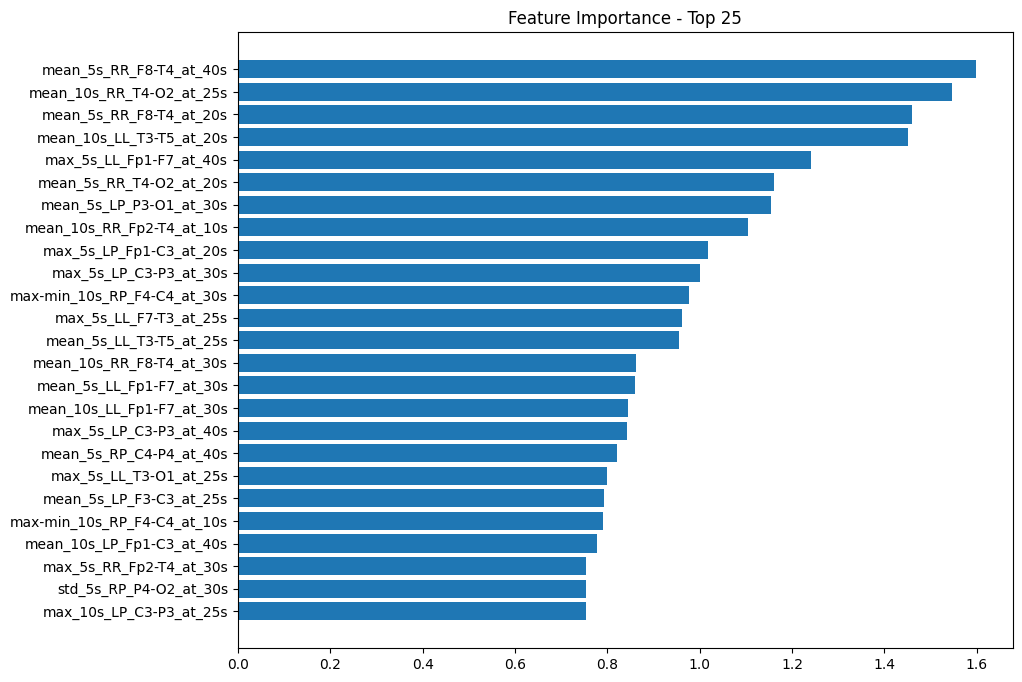

In [54]:
TOP = 25

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
plt.yticks(np.arange(len(sorted_idx))[-TOP:], np.array(FEATURES)[sorted_idx][-TOP:])
plt.title(f'Feature Importance - Top {TOP}')
plt.show()

# CV Score for CatBoost
This is CV score for our CatBoost model.

In [55]:
import sys
sys.path.append('../input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

oof.head()

,0,1,2,3,4,5,id
0,0.282334,0.152483,0.119410,0.038550,0.082940,0.324284,0
1,0.107468,0.040065,0.012347,0.009851,0.027876,0.802393,1
2,0.098343,0.180791,0.040402,0.095698,0.138017,0.446748,2
3,0.105720,0.433510,0.083405,0.035412,0.034946,0.307007,3
4,0.199134,0.129931,0.079586,0.039890,0.160066,0.391394,4


In [56]:
true.head()

,0,1,2,3,4,5,id
0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0
1,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1
2,0.066667,0.333333,0.0,0.2,0.066667,0.333333,2
3,1.000000,0.000000,0.0,0.0,0.000000,0.000000,3
4,0.000000,0.000000,0.0,0.0,1.000000,0.000000,4


In [57]:
# TARGETSの各列を正規化
oof_data = oof[[0, 1, 2, 3, 4, 5]].values
oof_data = oof_data / oof_data.sum(axis=1,keepdims=True)
oof[[0, 1, 2, 3, 4, 5]] = oof_data

In [58]:
oof.head()

,0,1,2,3,4,5,id
0,0.282334,0.152483,0.119410,0.038550,0.082940,0.324284,0
1,0.107468,0.040065,0.012347,0.009851,0.027876,0.802393,1
2,0.098343,0.180791,0.040402,0.095698,0.138017,0.446748,2
3,0.105720,0.433510,0.083405,0.035412,0.034946,0.307007,3
4,0.199134,0.129931,0.079586,0.039890,0.160066,0.391394,4


In [59]:
temp = pl.from_pandas(oof)

In [60]:
cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for CatBoost =',cv)

CV Score KL-Div for CatBoost = 1.1666203409357747


In [61]:
import sys
sys.path.append('../input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for CatBoost =',cv)

# CV Score KL-Divの保存
with open(f'models/CV_Score_v{VER}.txt', 'w') as f:
    f.write(str(cv) + "\n")

CV Score KL-Div for CatBoost = 1.1666203409357747
